# Imports

In [1]:
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn import metrics
from imblearn.combine import SMOTEENN
from collections import Counter

# Loading the Data

In [3]:
df = pd.read_csv("scraped\mission_launches.csv")
df

,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status
0,CASC,"LC-9A, Taiyuan Satellite Launch Center, China","Thu Dec 5, 2024 10:11 GMT+5:30",Long March 6A | G60 Polar Group 03,StatusActive,NaN,Success
1,SpaceX,"SLC-4E, Vandenberg SFB, California, USA","Thu Dec 5, 2024 08:35 GMT+5:30",Falcon 9 Block 5 | Starlink Group 9-14,StatusActive,69.75,Success
2,VKS RF,"Site 43/4, Plesetsk Cosmodrome, Russia","Wed Dec 4, 2024 23:29 GMT+5:30",Soyuz 2.1b | Cosmos 2580,StatusActive,20.00,Success
3,SpaceX,"SLC-40, Cape Canaveral SFS, Florida, USA","Wed Dec 4, 2024 15:43 GMT+5:30",Falcon 9 Block 5 | Starlink Group 6-70,StatusActive,69.75,Success
4,ExPace,"Mobile Launcher Pad, Xichang Satellite Launch ...","Wed Dec 4, 2024 10:16 GMT+5:30",Kuaizhou 1A | Haishao-1,StatusActive,5.80,Success
...,...,...,...,...,...,...,...
6926,US Navy,"LC-18A, Cape Canaveral SFS, Florida, USA","Wed Feb 5, 1958 13:03 GMT+5:30",Vanguard | Vanguard TV3BU,StatusRetired,NaN,Failure
6927,ABMA,"LC-26A, Cape Canaveral SFS, Florida, USA","Sat Feb 1, 1958 09:17 GMT+5:30",Juno I | Explorer 1,StatusRetired,NaN,Success
6928,US Navy,"LC-18A, Cape Canaveral SFS, Florida, USA","Fri Dec 6, 1957 22:14 GMT+5:30",Vanguard | Vanguard TV3,StatusRetired,NaN,Failure
6929,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan","Sun Nov 3, 1957 08:00 GMT+5:30",Sputnik 8K71PS | Sputnik 2,StatusRetired,NaN,Success


# Pre-Processing

In [4]:
df.head()

,Organisation,Location,Date,Detail,Rocket_Status,Price,Mission_Status
0,CASC,"LC-9A, Taiyuan Satellite Launch Center, China","Thu Dec 5, 2024 10:11 GMT+5:30",Long March 6A | G60 Polar Group 03,StatusActive,NaN,Success
1,SpaceX,"SLC-4E, Vandenberg SFB, California, USA","Thu Dec 5, 2024 08:35 GMT+5:30",Falcon 9 Block 5 | Starlink Group 9-14,StatusActive,69.75,Success
2,VKS RF,"Site 43/4, Plesetsk Cosmodrome, Russia","Wed Dec 4, 2024 23:29 GMT+5:30",Soyuz 2.1b | Cosmos 2580,StatusActive,20.00,Success
3,SpaceX,"SLC-40, Cape Canaveral SFS, Florida, USA","Wed Dec 4, 2024 15:43 GMT+5:30",Falcon 9 Block 5 | Starlink Group 6-70,StatusActive,69.75,Success
4,ExPace,"Mobile Launcher Pad, Xichang Satellite Launch ...","Wed Dec 4, 2024 10:16 GMT+5:30",Kuaizhou 1A | Haishao-1,StatusActive,5.80,Success


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6931 entries, 0 to 6930
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Organisation    6931 non-null   object 
 1   Location        6931 non-null   object 
 2   Date            6891 non-null   object 
 3   Detail          6931 non-null   object 
 4   Rocket_Status   6931 non-null   object 
 5   Price           2837 non-null   float64
 6   Mission_Status  6931 non-null   object 
dtypes: float64(1), object(6)
memory usage: 379.2+ KB


## Duplicates

In [6]:
df.drop_duplicates(inplace=True)

## NANs

In [7]:
df.isna().sum().to_frame(name="% of NANs") / df.shape[0] * 100

,% of NANs
Organisation,0.000000
Location,0.000000
Date,0.519781
Detail,0.000000
Rocket_Status,0.000000
Price,59.052844
Mission_Status,0.000000


In [8]:
df.drop(columns=['Price'], inplace=True)
df.dropna(inplace=True)
df.shape

(6890, 6)

Dropping NANs in `Date` and removing `Price` column

## Feature Engineering

### Date

In [9]:
df.Date.head()

0    Thu Dec 5, 2024 10:11 GMT+5:30
1    Thu Dec 5, 2024 08:35 GMT+5:30
2    Wed Dec 4, 2024 23:29 GMT+5:30
3    Wed Dec 4, 2024 15:43 GMT+5:30
4    Wed Dec 4, 2024 10:16 GMT+5:30
Name: Date, dtype: object

In [10]:
df["Date"].replace(to_replace=r'GMT', value="", regex = True, inplace=True)
df["Date"] = pd.to_datetime(df["Date"], format='mixed')
df[["Date"]].head()

,Date
0,2024-12-05 10:11:00+05:30
1,2024-12-05 08:35:00+05:30
2,2024-12-04 23:29:00+05:30
3,2024-12-04 15:43:00+05:30
4,2024-12-04 10:16:00+05:30


In [11]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df["WeekofMonth"] = ((df['Date'].dt.day - 1) // 7 + 1)
df['DayofMonth'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Hour'] = df['Date'].dt.hour
df.drop("Date", axis=1, inplace=True)

In [12]:
df.sample()

,Organisation,Location,Detail,Rocket_Status,Mission_Status,Year,Month,WeekofMonth,DayofMonth,DayOfWeek,Hour
4684,RVSN USSR,"Site 31/6, Baikonur Cosmodrome, Kazakhstan",Soyuz U | Soyuz 34,StatusRetired,Success,1979,6,1,6,2,23


### Detail

In [13]:
df.head()

,Organisation,Location,Detail,Rocket_Status,Mission_Status,Year,Month,WeekofMonth,DayofMonth,DayOfWeek,Hour
0,CASC,"LC-9A, Taiyuan Satellite Launch Center, China",Long March 6A | G60 Polar Group 03,StatusActive,Success,2024,12,1,5,3,10
1,SpaceX,"SLC-4E, Vandenberg SFB, California, USA",Falcon 9 Block 5 | Starlink Group 9-14,StatusActive,Success,2024,12,1,5,3,8
2,VKS RF,"Site 43/4, Plesetsk Cosmodrome, Russia",Soyuz 2.1b | Cosmos 2580,StatusActive,Success,2024,12,1,4,2,23
3,SpaceX,"SLC-40, Cape Canaveral SFS, Florida, USA",Falcon 9 Block 5 | Starlink Group 6-70,StatusActive,Success,2024,12,1,4,2,15
4,ExPace,"Mobile Launcher Pad, Xichang Satellite Launch ...",Kuaizhou 1A | Haishao-1,StatusActive,Success,2024,12,1,4,2,10


In [14]:
detail_cols = df['Detail'].str.split(r' | ', expand=True, regex=False)
df.drop("Detail", axis=1, inplace=True)

In [15]:
df.insert(3, column='Rocket', value=detail_cols.iloc[:,0])
df.insert(4, column='Mission', value=detail_cols.iloc[:,1])

### Rocket Status

In [16]:
df["Rocket_Status"].value_counts().to_frame()

,count
Rocket_Status,
StatusRetired,5376
StatusActive,1514


In [17]:
df["Rocket_Status"] = df["Rocket_Status"].str.strip(r'Status')

### Location

In [18]:
df["Location"].value_counts().to_frame()

,count
Location,
"Site 1/5, Baikonur Cosmodrome, Kazakhstan",486
"Site 31/6, Baikonur Cosmodrome, Kazakhstan",420
"Site 43/4, Plesetsk Cosmodrome, Russia",327
"Site 41/1, Plesetsk Cosmodrome, Russia",309
"SLC-40, Cape Canaveral SFS, Florida, USA",276
...,...
"K-84 Submarine, Barents Sea Launch Area, Barents Sea",1
"DeBo 3 Barge, China Coastal Waters",1
"Tai Rui Barge (Area 1), China Coastal Waters",1


In [19]:
df["Launch Pad"] = df["Location"].str.extract(r'^([^,]+)')
df["Country"] = df["Location"].str.extract(r'([\w\s]+)$')
df.drop("Location", axis=1, inplace=True)
df[["Launch Pad", "Country"]]

,Launch Pad,Country
0,LC-9A,China
1,SLC-4E,USA
2,Site 43/4,Russia
3,SLC-40,USA
4,Mobile Launcher Pad,China
...,...,...
6926,LC-18A,USA
6927,LC-26A,USA
6928,LC-18A,USA
6929,Site 1/5,Kazakhstan


### Mission_Status: *Target*

In [20]:
df["Mission_Status"].value_counts()

Mission_Status
Success              6324
Failure               445
Partial Failure       116
Prelaunch Failure       5
Name: count, dtype: int64

<Axes: xlabel='Mission_Status'>

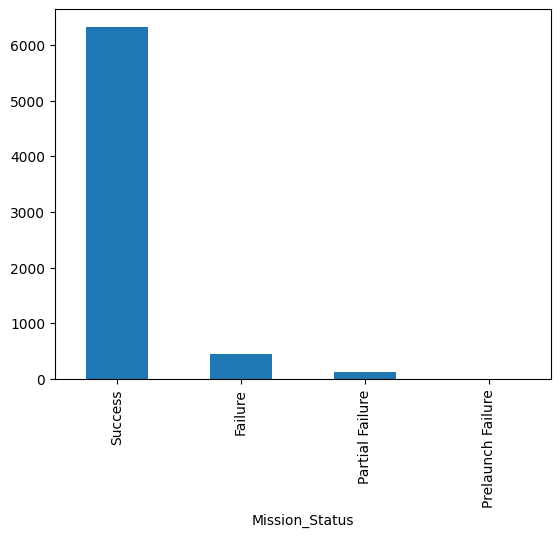

In [21]:
df["Mission_Status"].value_counts().plot(kind='bar')

Classes are extremely imbalanced

In [22]:
df["Mission_Status"] = df["Mission_Status"].replace(
    {
        "Failure": "Not Success",
        "Partial Failure": "Not Success",
        "Prelaunch Failure": "Not Success",
    }
)
df["Mission_Status"].value_counts()

Mission_Status
Success        6324
Not Success     566
Name: count, dtype: int64

In [23]:
df["Mission_Status"].value_counts() / df["Mission_Status"].value_counts().sum() * 100

Mission_Status
Success        91.785196
Not Success     8.214804
Name: count, dtype: float64

## Feature Encoding & Selection

### Encoding

In [24]:
# Specify feature groups
ordinal_features = ["Organisation", "Rocket", "Mission", "Launch Pad", "Country"]
onehot_feature = ["Rocket_Status"]
numerical_features = ["Year", "Month", "WeekofMonth", "DayofMonth", "DayOfWeek", "Hour"]
target = "Mission_Status"

df = df[ordinal_features + onehot_feature + numerical_features + [target]]
X = df.drop(target, axis=1)
y = df[target]

preprocessor = ColumnTransformer([
    ("ordinal", OrdinalEncoder(), ordinal_features),
    ("onehot", OneHotEncoder(drop="first"), onehot_feature),
    ("passthrough", "passthrough", numerical_features),
])
X_encoded = preprocessor.fit_transform(X)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [25]:
# Saving the feature ranges
num_feature_ranges = X.describe().astype(int).loc[["min", "max", "mean"]].to_dict()
joblib.dump(num_feature_ranges, "feature_ranges.pkl")

['feature_ranges.pkl']

In [26]:
pd.DataFrame(X_encoded, columns=X.columns)

,Organisation,Rocket,Mission,Launch Pad,Country,Rocket_Status,Year,Month,WeekofMonth,DayofMonth,DayOfWeek,Hour
0,12.0,240.0,3077.0,51.0,3.0,0.0,2024.0,12.0,1.0,5.0,3.0,10.0
1,60.0,172.0,6155.0,90.0,20.0,0.0,2024.0,12.0,1.0,5.0,3.0,8.0
2,66.0,349.0,1870.0,132.0,18.0,0.0,2024.0,12.0,1.0,4.0,2.0,23.0
3,60.0,172.0,6116.0,87.0,20.0,0.0,2024.0,12.0,1.0,4.0,2.0,15.0
4,21.0,204.0,3432.0,63.0,3.0,0.0,2024.0,12.0,1.0,4.0,2.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6885,64.0,427.0,6553.0,34.0,20.0,1.0,1958.0,2.0,1.0,5.0,2.0,13.0
6886,1.0,193.0,2910.0,39.0,20.0,1.0,1958.0,2.0,1.0,1.0,5.0,9.0
6887,64.0,427.0,6552.0,34.0,20.0,1.0,1957.0,12.0,1.0,6.0,4.0,22.0
6888,50.0,374.0,5968.0,100.0,11.0,1.0,1957.0,11.0,1.0,3.0,6.0,8.0


In [27]:
pd.DataFrame(y_encoded, columns=[y.name])

,Mission_Status
0,1
1,1
2,1
3,1
4,1
...,...
6885,0
6886,1
6887,0
6888,1


In [28]:
X, y = X_encoded, y_encoded

In [29]:
joblib.dump(preprocessor, 'preprocessor.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

['label_encoder.pkl']

### Balancing the priors

In [30]:
# Apply Hybrid Sampling (SMOTE + Edited Nearest Neighbors)
smote_enn = SMOTEENN(sampling_strategy=0.5, random_state=42)  # Balance up to 50% of majority class
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

# Check new class distribution
print("Original Class Distribution:", Counter(y))
print("New Class Distribution:", Counter(y_resampled))

Original Class Distribution: Counter({1: 6324, 0: 566})
New Class Distribution: Counter({1: 5024, 0: 2228})


In [31]:
X, y = X_resampled, y_resampled

## Train-Test Split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Modelling: RandomForest

In [33]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [34]:
rfc.score(X_train, y_train)

1.0

In [35]:
rfc.score(X_test, y_test)

0.9773855488141202

In [36]:
y_pred_test = rfc.predict(X_test)

## Confusion Matrix

Confision matrix on Testing data

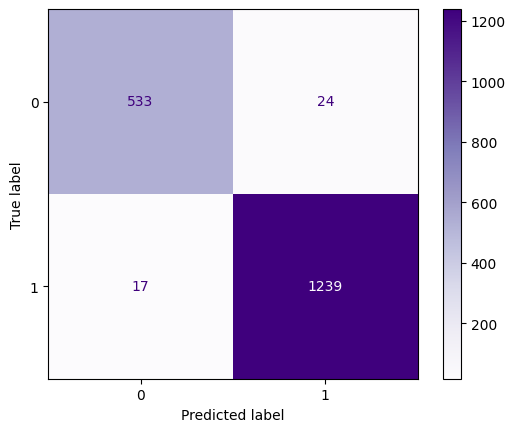

In [37]:
cm_test = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=rfc.classes_)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=rfc.classes_).plot(cmap='Purples')
plt.grid(False)
plt.show()

## Classification Report

In [38]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       557
           1       0.98      0.99      0.98      1256

    accuracy                           0.98      1813
   macro avg       0.98      0.97      0.97      1813
weighted avg       0.98      0.98      0.98      1813



## ROC & AUC

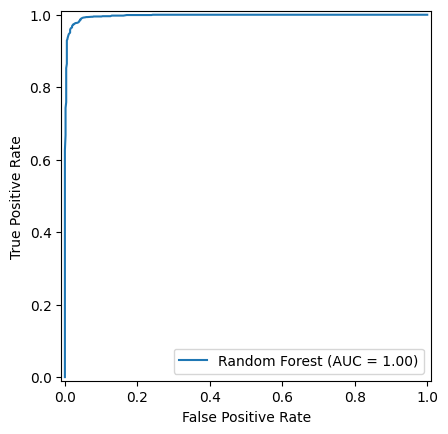

In [39]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, rfc.predict_proba(X_test)[:,1])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="Random Forest"
)

display.plot()
plt.show()

This Random Forest model seems to be the model with the highest accuracy of **98%**. (It does seem to overfit a bit because of SMOTEEN)

In [40]:
# Saving the best performing model
joblib.dump(rfc, 'rfc_model.pkl')

['rfc_model.pkl']

# Modelling: AdaBoost

In [41]:
adaBoost_clf = AdaBoostClassifier(random_state=42)

In [42]:
adaBoost_clf.fit(X_train, y_train)

AdaBoostClassifier(random_state=42)

In [43]:
adaBoost_clf.score(X_train, y_train)

0.8939143224857511

In [44]:
adaBoost_clf.score(X_test, y_test)

0.8841698841698842

In [45]:
y_pred_test = adaBoost_clf.predict(X_test)

## Confusion Matrix

Confision matrix on Testing data

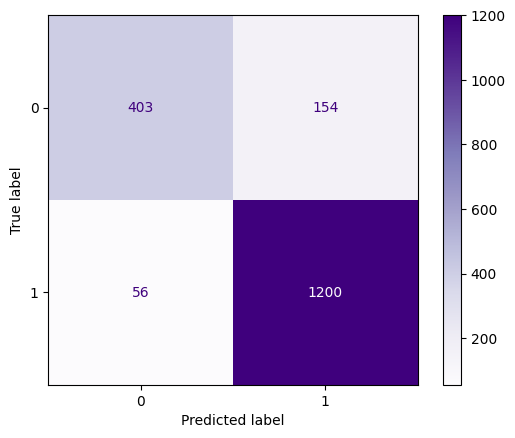

In [46]:
cm_test = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred_test, labels=adaBoost_clf.classes_)
metrics.ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=adaBoost_clf.classes_).plot(cmap='Purples')
plt.grid(False)
plt.show()

## Classification Report

In [47]:
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79       557
           1       0.89      0.96      0.92      1256

    accuracy                           0.88      1813
   macro avg       0.88      0.84      0.86      1813
weighted avg       0.88      0.88      0.88      1813



## ROC & AUC

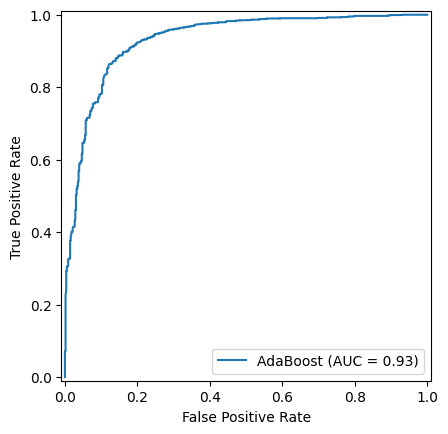

In [48]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, adaBoost_clf.predict_proba(X_test)[:,1])
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(
    fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name="AdaBoost"
)

display.plot()
plt.show()

## Hyperparameter tuning

*10-Fold Cross-Validation:* On AdaBoost

In [49]:
param_grid = {
    "n_estimators": [5, 10, 25, 50, 100, 500],
    "learning_rate": [0.0001, 0.001, 0.1, 0.5, 1.0],
}

In [50]:
adaboost_grid = GridSearchCV(adaBoost_clf, param_grid, cv=10, n_jobs=-1)

In [51]:
adaboost_grid.fit(X, y)

GridSearchCV(cv=10, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.0001, 0.001, 0.1, 0.5, 1.0],
                         'n_estimators': [5, 10, 25, 50, 100, 500]})

In [52]:
adaboost_grid.score(X_test, y_test)

0.9305019305019305

In [53]:
best_params = adaboost_grid.best_params_
best_params

{'learning_rate': 0.5, 'n_estimators': 500}

In [54]:
adaBoost_clf_best = AdaBoostClassifier(**best_params, random_state=42)

In [55]:
adaBoost_clf_best.fit(X, y)

AdaBoostClassifier(learning_rate=0.5, n_estimators=500, random_state=42)

In [56]:
y_pred = adaBoost_clf_best.predict(X)

In [57]:
acc_cv_score = cross_val_score(adaBoost_clf_best, X, y, scoring='accuracy', cv=10)
acc_cv_score.mean()

0.8483243089199201

In [58]:
cv_scores = cross_validate(
    adaBoost_clf_best, X, y, cv=10, scoring=("accuracy", "balanced_accuracy", "precision", "recall", "f1"), return_train_score=False, n_jobs=-1
)
pd.DataFrame(cv_scores).describe()[1:]

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_precision,test_recall,test_f1
mean,7.245199,0.280442,0.848324,0.832056,0.834880,0.874525,0.847662
std,1.576279,0.076675,0.213055,0.178241,0.266840,0.306558,0.296620
min,4.255506,0.130693,0.274483,0.444424,0.103448,0.005964,0.011278
25%,7.768743,0.308547,0.906552,0.891993,0.917787,0.946713,0.931305
50%,7.947374,0.316016,0.927638,0.902848,0.939106,0.984084,0.948782
75%,8.105560,0.319545,0.944483,0.919910,0.950572,0.990040,0.961096
max,8.146178,0.323668,0.964138,0.949181,0.961240,0.996024,0.974460


In [59]:
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      2228
           1       0.92      0.98      0.95      5024

    accuracy                           0.93      7252
   macro avg       0.94      0.90      0.92      7252
weighted avg       0.93      0.93      0.93      7252

